In [1]:
import sys
sys.path.append("./source")

# libraries for this project
from lmmNet import *
import harmonic
import train_onestep
import predict_onestep
import predict_lmmNet

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.base import clone
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

# 1. Data Preparation

Here we test our methods on the 2-D Cubic Harmonic Oscillator

$$ \begin{array}
\dot{x_1} & = & -0.1 x_1^3 + 2.0 x_2^3 \\
\dot{x_2} & = & -2.0 x_1^3 - 0.1 x_2^3 \\
\end{array} $$

with the initial conditions $x_1(0) = 2, x_2(0) = 0$. We will use three different approaches:
1. LmmNet
2. One-step machine learning method
3. Recurrent approach

We will also investigate how the method performs under noisy conditions.

In [2]:
time_points, cubic_data = harmonic.simulate_default()

Text(0.5, 1.0, 'Phase Portrait of the 2-D Harmonic Oscillator')

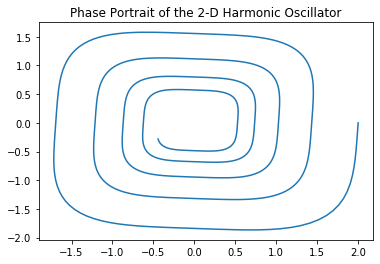

In [3]:
# Phase plane plot
plt.plot(cubic_data[0,:,0], cubic_data[0,:,1])
plt.title('Phase Portrait of the 2-D Harmonic Oscillator')

Now that we have simulated a dataset, let's create a suitable training data and augment it for learning.

# 2. LmmNet

Next, we train the LmmNet on the tensor data.

In [5]:
# we specify a LMM scheme and number of steps
dt = time_points[1] - time_points[0]
M = 1
scheme = 'AM'
model = lmmNet(dt, cubic_data, M, scheme, hidden_units=256)

N_Iter = 10000
model.train(N_Iter, debug=False)

In [7]:
import predict_lmmNet

x0 = cubic_data[0,0,:] # initial conditions
predicted_traj = odeint(lambda x, t: predict_lmmNet.predict_fn(x, t, model), x0, time_points)

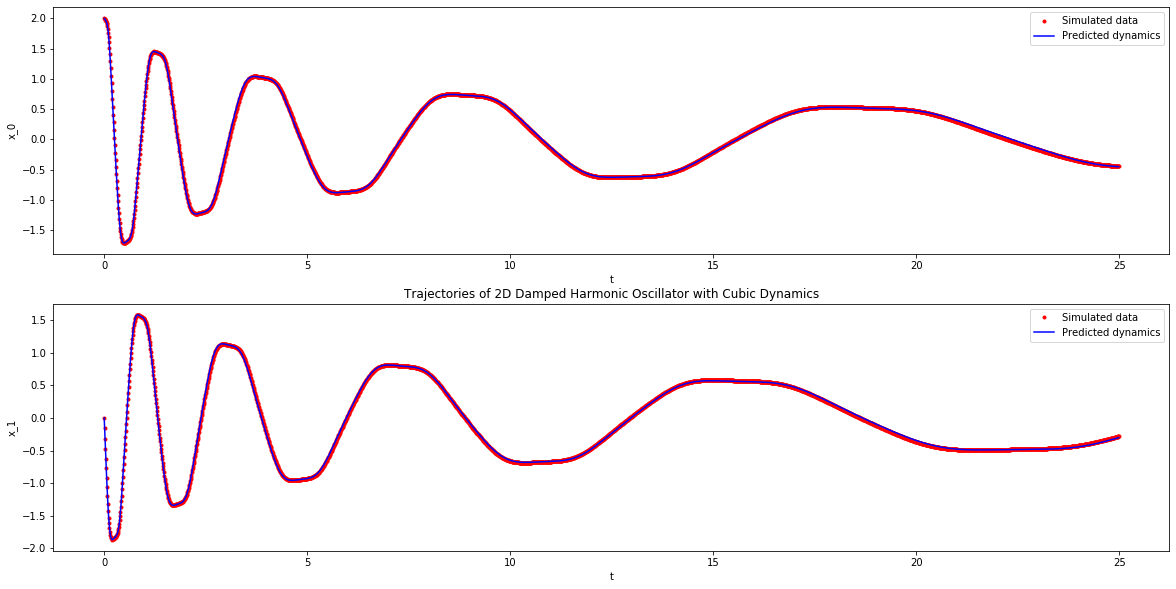

In [10]:
# plot the time-course of the predicted trajectory

plt.figure(figsize=(20, 10))

for species in range(2):
    plt.subplot(2,1,species + 1)
    plt.plot(time_points, cubic_data[0,:, species], 'r.', label='Simulated data')
    plt.plot(time_points, predicted_traj[:,species], 'b-', label='Predicted dynamics')
    plt.xlabel('t')
    plt.ylabel('x_' + str(species))
    plt.legend()
    
plt.title('Trajectories of 2D Damped Harmonic Oscillator with Cubic Dynamics')
plt.show()

Text(0.5, 1.0, 'Phase plane of 2D Damped Harmonic Oscillator with Cubic Dynamics')

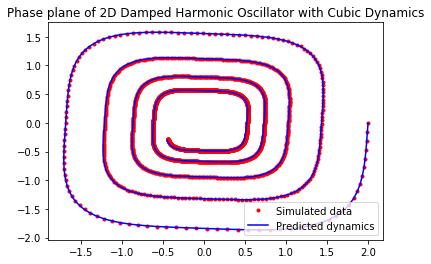

In [11]:
# Phase plane

plt.plot(cubic_data[0,:,0], cubic_data[0,:,1], 'r.', label='Simulated data')
plt.legend()
plt.plot(predicted_traj[:,0], predicted_traj[:,1], 'b-', label='Predicted dynamics')
plt.legend()
plt.title('Phase plane of 2D Damped Harmonic Oscillator with Cubic Dynamics')

# 3. One-step machine learning method

Workflow:
* create and augment training data
* fit model with pairs of derivatives and time-series measurements as features
* make predictions and simulations by numerical integration of the learned model

In [26]:
# function to prepare data for training one-step method

def create_data(cubic_data, num=0):
    df = pd.DataFrame(cubic_data.numpy()[0])
    df.columns = ['x_component', 'y_component']
    df['Strain'] = [num] * df.shape[0]
    df = df.set_index('Strain')
    df['Time'] = time_points
    print('Original data shape:', df.shape)
    return df

# now generate and augment the training dataset
df = create_data(cubic_data)
feature_list = [] # here we do not have external time-series or control variables
target_list = ['x_component', 'y_component']

Original data shape: (2500, 3)


In [9]:
# create training data with different augmentation

df_train = train_onestep.generate_dataset(df, [0],feature_list, target_list, n_dim=2500)
df_train2 = train_onestep.generate_dataset(df, [0],feature_list, target_list, n_dim=5000)
df_train3 = train_onestep.generate_dataset(df, [0],feature_list, target_list, n_dim=30000)

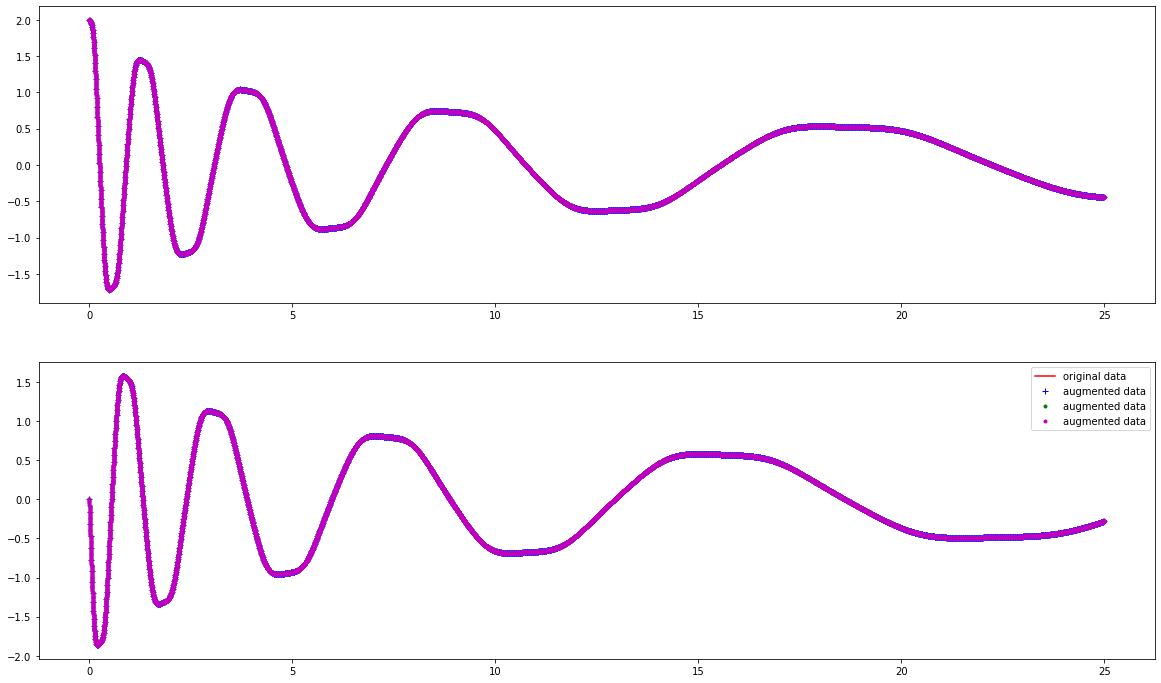

In [10]:
# make sure the augmented data corresponds to the original data

plt.figure(figsize = (20, 12))
for species in range(2):
    plt.subplot(2, 1, species + 1)
    plt.plot(time_points, df.iloc[:,species], 'r-', label='original data')
    plt.plot(time_points, df_train[('feature', df.columns[species])], 'b+', label='augmented data')
    plt.plot(df_train2.index.get_level_values(1), df_train2[('feature', df.columns[species])], 'g.', label='augmented data')
    plt.plot(df_train3.index.get_level_values(1), df_train3[('feature', df.columns[species])], 'm.', label='augmented data')
plt.legend()

In [ ]:
# train model and make predictions

def end_to_end_training(df, df_train, df_test):
    """
    df_train: training data augmented
    df_test: test data raw
    df: training data raw
    """
    rf_model = RandomForestRegressor(n_estimators=20)
    figure_path = './plots/'
    rf_dict, score_dict = train_onestep.train_classic(df_train, rf_model, plot=True,model_type='random_forest', figure_path=figure_path)
    train_onestep.compute_error(df_train,rf_dict,plot=True,model_type='random_forest')
    # now we make predictions via numerical integration
    # note that in predict_integrate, the function expects a normal dataframe and not the time-series multi-index dataframe
    time_points, predictions = predict_onestep.predict_integrate(df, df_test, rf_dict, target_list, feature_list, title='damped harmonic', plot=True,model_type='random_forest', subplots=(2,1), bio=False)
    return time_points, predictions

tp1, pred1 = end_to_end_training(df, df_train, df_train)
tp2, pred2 = end_to_end_training(df, df_train2, df_train2)
tp3, pred3 = end_to_end_training(df, df_train3, df_train3)

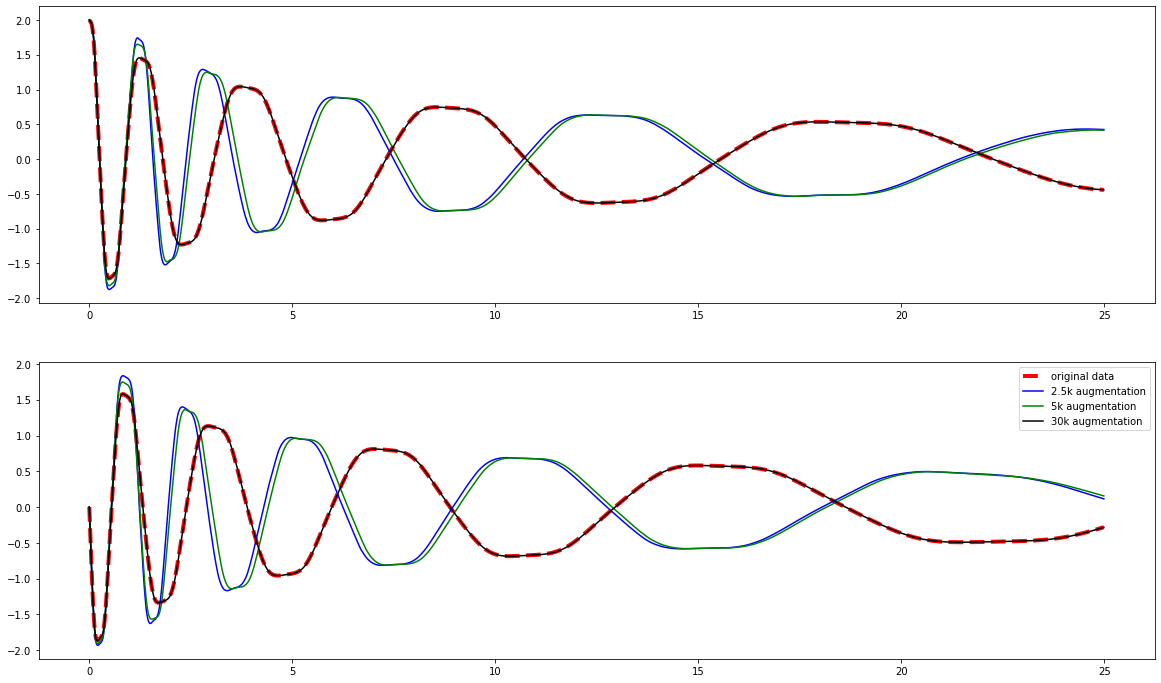

In [20]:
# plot the predictions in one figure

# make sure the augmented data corresponds to the original data
plt.figure(figsize = (20, 12))
for species in range(2):
    plt.subplot(2, 1, species + 1)
    plt.plot(time_points, df.iloc[:,species], 'r--', linewidth=4, label='original data')
    plt.plot(tp1, pred1.iloc[:,species], 'b-', label='2.5k augmentation')
    plt.plot(tp2, pred2.iloc[:,species], 'g-', label='5k augmentation')
    plt.plot(tp3, pred3.iloc[:,species], 'k-', label='30k augmentation')
    
plt.legend()

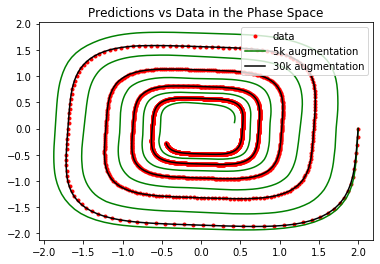

In [22]:
# Phase plane plot
plt.plot(cubic_data[0,:,0], cubic_data[0,:,1], 'r.', label='data')
plt.plot(pred1.iloc[:,0], pred1.iloc[:,1], 'g-', label='5k augmentation')
plt.plot(pred3.iloc[:,0], pred3.iloc[:,1], 'k-', label='30k augmentation')
plt.title('Predictions vs Data in the Phase Space')
plt.legend()

# 4. Prediction on unseen initial values

Let's evaluate the model on unseen initial conditions.

Original data shape: (2500, 3)
x_component


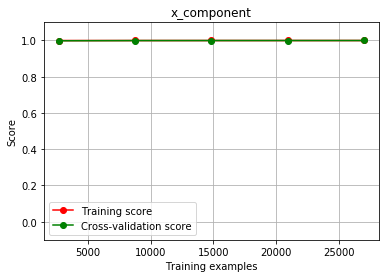

Target: x_component, CV Pearson R2 coefficient: 0.999989
y_component


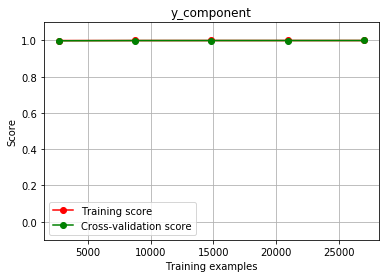

Target: y_component, CV Pearson R2 coefficient: 0.999992
Average training score: 0.9999904168674925
x_component RMSE: 0.00010072326082614508 standard deviation: 0.005819476775719067


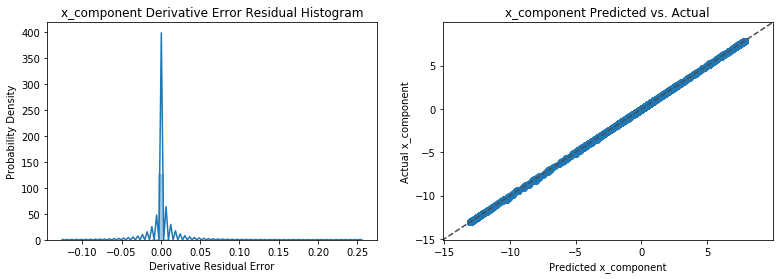

y_component RMSE: -8.749564690852104e-05 standard deviation: 0.005226541818560516


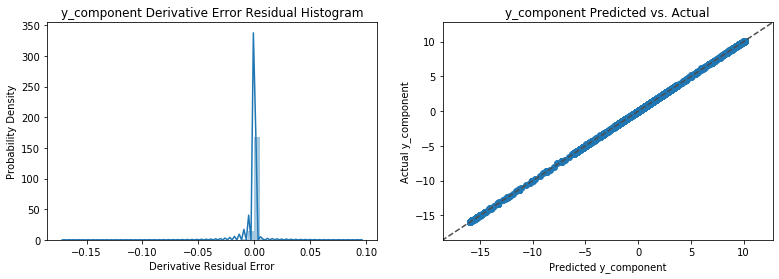

Total Derivative Mean Error: 0.014238465595776689 Error Standard Deviation: 0.0248392338350548


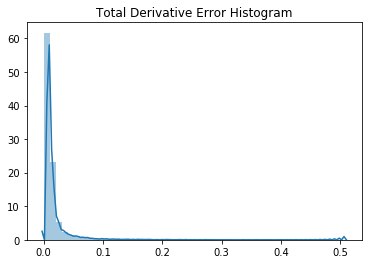

Real data:


,x_component,y_component
Strain,,
0,2.000000,0.000000
0,1.992028,-0.159044
0,1.983873,-0.316164
0,1.974847,-0.471225
0,1.963856,-0.623866
...,...,...
0,-0.441769,-0.288236
0,-0.442157,-0.286486
0,-0.442536,-0.284731


Predicted data:


,x_component,y_component
Time,,
0.00,2.000000,0.000000
0.01,1.992024,-0.159077
0.02,1.983843,-0.316211
0.03,1.974880,-0.471280
0.04,1.964118,-0.623844
...,...,...
24.95,-0.441728,-0.291934
24.96,-0.442124,-0.290189
24.97,-0.442508,-0.288438


./source/predict_onestep.py:217: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  rmse = math.sqrt(quad(integrand,min(times),max(times),limit=200)[0])
./source/predict_onestep.py:222: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  rmsep = math.sqrt(quad(percent_integrand,min(times),max(times),limit=200)[0])


ML Fit: x_component 0.023316352486684642 RMSE percentage: 28.76785369758592


./source/predict_onestep.py:222: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  rmsep = math.sqrt(quad(percent_integrand,min(times),max(times),limit=200)[0])


ML Fit: y_component 0.02293136446939796 RMSE percentage: 15.064531958196037
ML model aggregate error
Average RMSE: 0.0231238584780413
Total percentage error: 21.916192827890978


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


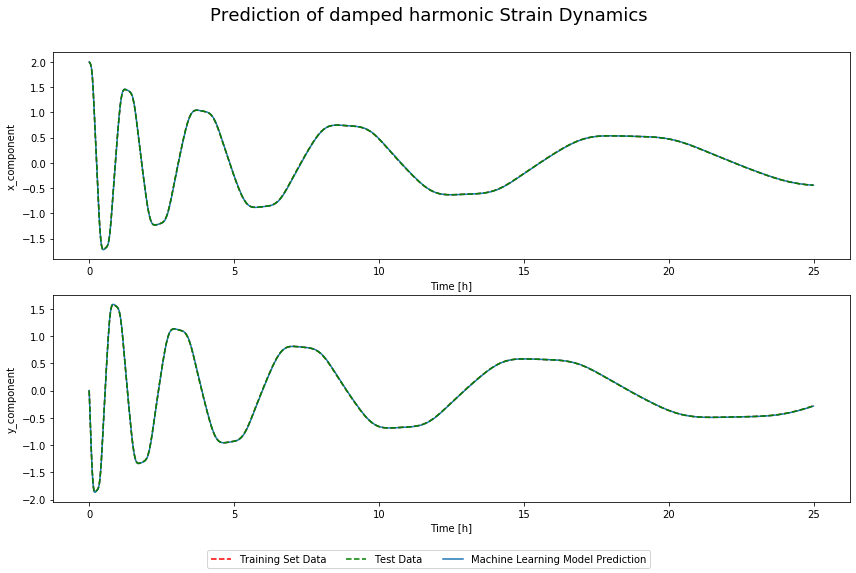

In [28]:
time_points, data2 = harmonic.simulate_custom(xinit=3, yinit=4)
df2 = create_data(data2, num=1)
tp, pred = end_to_end_training(df, df_train3, df2)